# Session 1

Let's get hands-on! During today's exercise, we will be starting from the basics: 
- Accessing the data files from the ATLAS Open Data website.
- The tools you will be using to access and visualise: $\texttt{python}$ in $\texttt{jupyter notebook}$, $\texttt{numpy}$ (this session) and finally ROOT (next session).
- Histograms and data analysis with $\texttt{numpy}$.
- Lorentz vectors and data analysis with $\texttt{numpy}$.

## ATLAS Open Data

[ATLAS Open Data](http://opendata.atlas.cern/) is an open dataset of both simulated and real proton-proton collision events. 
We will be using the [ATLAS 13 TeV Open Dataset](http://opendata.atlas.cern/release/2020/documentation/datasets/intro.html). 


## Analysis Tools


In today's session we will be using $\texttt{uproot}$ and $\texttt{numpy}$ to access events in ATLAS Open Data data files. Uproot is a python serialisation library that converts files from a ROOT format (a data format ubiqitiously used in High Energy Physics analysis) to regular arrays so we can manipulate it using regular but powerful python libraries. Specifically, we will be "uprooting" the data to arrays in $\texttt{numpy}$, a python library for multidimensional array and matrix manipulation.


We will be analysing the particles from a simulation of the following process:
(insert figure)
That is, the production of a W-boson and a Z-boson. 

Some important terminology:
- "leading" particle: The particle (lepton, quark) with the highest measured transverse momentum.
- "subleading" particle: The particle (lepton, quark) with the *second* highest measured transverse momentum.
(we similarly get "subsubleading", and "subsubsubleading"...)






In [2]:
# Let's first import the necessary libraries and define our global variables
import uproot
import numpy as np

base_url = 'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/MC/'
input_file =  'mc_410000.ttbar_lep.2lep.root'#'mc_363358.WqqZll.2lep.root' # 'mc_410000.ttbar_lep.2lep.root'
tree_name = 'mini' # event "tree" in which information of each event in the data set are defined:
                   # event level information, particles and their properties

In [3]:
# Next we read in the content file and print the file content

#with uproot.open(f"{base_url}/{input_file}:{tree_name}") as events:
#    print('opened dataset containing:\n', events.show())


events = uproot.open(f"{base_url}/{input_file}:{tree_name}")
print('opened dataset containing:\n', events.show())


name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
eventNumber          | int32_t                  | AsDtype('>i4')
channelNumber        | int32_t                  | AsDtype('>i4')
mcWeight             | float                    | AsDtype('>f4')
scaleFactor_PILEUP   | float                    | AsDtype('>f4')
scaleFactor_ELE      | float                    | AsDtype('>f4')
scaleFactor_MUON     | float                    | AsDtype('>f4')
scaleFactor_PHOTON   | float                    | AsDtype('>f4')
scaleFactor_TAU      | float                    | AsDtype('>f4')
scaleFactor_BTAG     | float                    | AsDtype('>f4')
scaleFactor_LepTR... | float                    | AsDtype('>f4')
scaleFactor_Photo... | float                    | AsDtype('>f4')
trigE                | bool                     | AsDtype(

In [6]:
# now lets convert the variables we want to analyse into numpy arrays. THIS MAY TAKE A FEW SECONDS!
# The resulting 'lep_kinematics' variable is known as a structured numpy array.
lep_kinematics = events.arrays(['lep_n', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E'], library="np")                    

print("Number of leptons in first 5 events:\n", lep_kinematics['lep_n'][:5])
print('particle kinematics of leading lepton in first 5 events:')
for i in range(5):
    if lep_kinematics['lep_n'][i] >=1:
        print('lepton pT: %i MeV, eta: %f.2, phi: %f.2.'%(lep_kinematics['lep_pt'][i][0],lep_kinematics['lep_eta'][i][0], lep_kinematics['lep_phi'][i][0]))
    else:
        print("WARNING No leptons found in this event (number of leptons = %i)"%(lep_kinematics['lep_n'][i]))


Number of leptons in first 5 events:
 [2 2 2 2 2]
particle kinematics of leading lepton in first 5 events:
lepton pT: 68258 MeV, eta: 0.573097.2, phi: 2.797778.2.
lepton pT: 35269 MeV, eta: -1.321083.2, phi: -1.891969.2.
lepton pT: 59904 MeV, eta: -1.798291.2, phi: -2.042090.2.
lepton pT: 62116 MeV, eta: -0.077092.2, phi: 0.415694.2.
lepton pT: 52995 MeV, eta: 0.484091.2, phi: -0.398400.2.


### Histograms

Histograms are fundamental to data analysis. They are a graphical representation of the distribution of a dataset; A way to visualize the frequency distribution of a set of continuous or discrete data.
In particle physics, histograms are often used to visualize the distribution of particle properties such as energy, momentum, or mass. A histogram is created by dividing a variable range into a set of "bins" and counting the number of times a particle or event property falls in that bin. Thus, the height of a histogram represents the frequency of events that fall into that bin.

Histograms can be very useful for understanding features in your data. Here, for example is the distribution of the size of all exo-planets in the Kepler space mission database, showing that smaller planets are more common than massive planets:
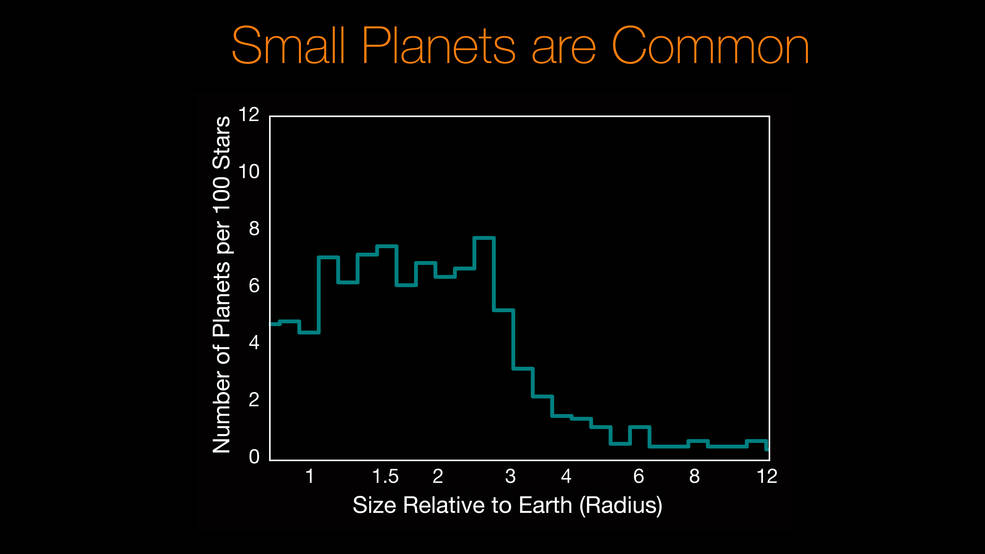

Interestingly, when they refined their measurements, they began to see multiple distributions:
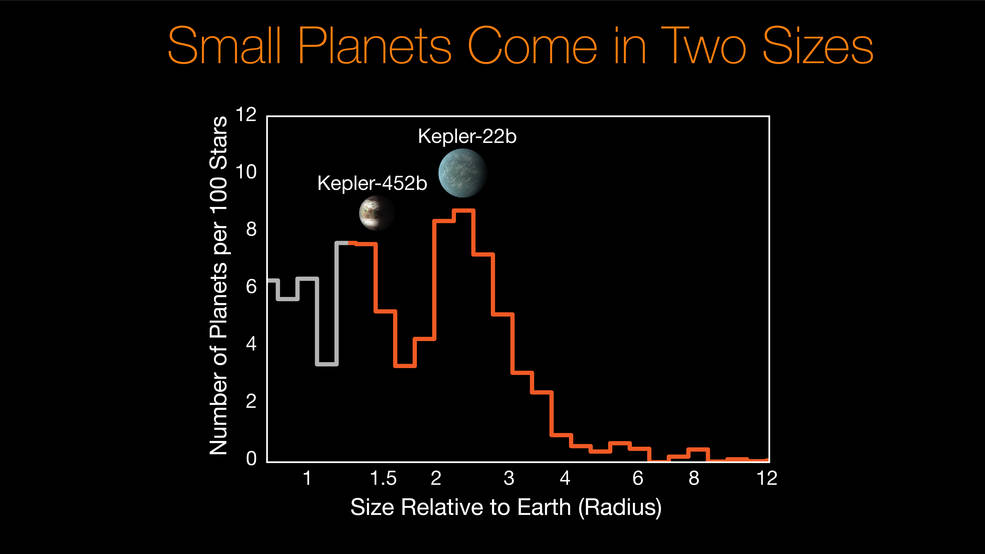

(ref: [NASA Kepler website](https://www.nasa.gov/ames/kepler/briefing-materials-final-kepler-survey-catalog-of-planet-candidates-in-the-cygnus-field))

A histogram can also be normalised which changes the definition of its content. For example, in the Kepler histograms above each bin measures the number of planets per 100 stars, which is in effect a rate measurement: There are roughly 6 Earth-sized planets for every 100 stars.
If one were to sum the counts (all bin heights) and divide all bin counts by the total sum, one would get a density distribution: The fraction of planets of a certain radius.

### Making a histogram

Let's make a histogram of some particle variables. A histogram is defined by two arrays: the bin edges and the number of entries in each bin. 

#### Side note: Underflows and overflows

> When defining a histogram you need to choose the total range over which the data will be represented as you will be choosing the first bin edge and the last bin edge. Any data that falls outside of this range can be filled in the so-called "underflow" and "overflow" bins. As the under- and overflow bins theoretically don't have a lower and and upper edge, respectively, they will not accurately represent the continued data distribution. Thus they are not commonly plotted as part of the histogram, however it is sometimes useful to know the fraction of data your histogram is representing relative to the fraction outside its range.

Below you will choose your own particle properties and make histogram distributions.


#### Retrieving variables and making a histogram
Refer to the print out in the second cell of the notebook or see the [ATLAS Open Data Website here](http://opendata.atlas.cern/release/2020/documentation/datasets/dataset13.html) for a list of variables in the dataset. Ask us if you don't understand what a variable means! We will also gradually be learning about most of these variables during this course.

In [14]:
# first, retrieve the data you want. 

list_of_variables = []  # <-- ADD YOUR VARIABLES HERE
particle_arrays = events.arrays(list_of_variables, library="np") 

# You may want to print out your variables of interest for a subset of events to get an idea of their magnitude:
for key in particle_arrays:
    print(key, " for first 3 events:\n", particle_arrays[key][:3])


lep_pt  for first 3 events:
 [array([68258.74 , 32021.346], dtype=float32)
 array([35269.156, 13273.811], dtype=float32)
 array([59904.75 , 16296.021], dtype=float32)]
lep_eta  for first 3 events:
 [array([ 0.57309675, -0.52021176], dtype=float32)
 array([-1.3210831, -1.9384617], dtype=float32)
 array([-1.7982911, -2.5536802], dtype=float32)]


In [32]:
# next, define your histogram in numpy
# Remember, a histogram consists of 2 arrays: The bin edges, and the bin counts.
# The bin edges are defined by the minimum and maximum value of the variable range, and the bin width 
# (the value range that each bin represents).
# While histograms do *not* have to have bins of equal width, lets choose one bin size.

# ADJUST these parameters to make it suitable to the variable you are looking at.
bin_width = 5 
hist_min = 0
hist_max = 100
bins = int((hist_max-hist_min)/bin_width)

bin_edges = np.array(np.arange(0, hist_max+bin_width, bin_width))
print('histogram bin edges: ', bin_edges)
print('total number of histogram bin edges: ', len(bin_edges), "to define ", bins, "bins.")

histogram bin edges:  [  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]
total number of histogram bin edges:  21 to define  20 bins.


In [51]:
# Now make and fill the bins!
# Lets ignore underflow and overflow bins for now.

var_key = 'lep_pt' # fill me with chosen variable

bin_entries = np.array(np.zeros(len(bin_edges)-1)) # bin entry has size number of bin edges - 1, as bin edges define boundaries 

for ii,var in enumerate(particle_arrays[var_key]):
    print("Processing ", var, " for event ", ii) # REMOVE this and fill histogram array
    if ii > 3: break                             # REMOVE this and fill histogram array
print("histogram bin entries: ", bin_entries)
print("histogram total bins (including under- and overflow): ", len(bin_entries))


Processing  [68258.74  32021.346]  for event  0
Processing  [35269.156 13273.811]  for event  1
Processing  [59904.75  16296.021]  for event  2
Processing  [62116.527 30084.5  ]  for event  3
Processing  [52995.56 20755.71]  for event  4
histogram bin entries:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
histogram total bins (including under- and overflow):  20


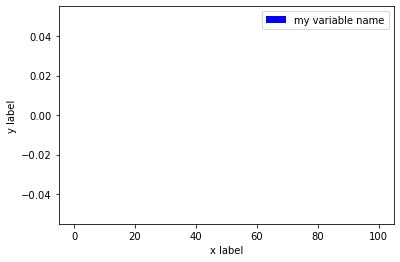

In [52]:
# Now we draw it using matplotlib's bar option.

import matplotlib.pyplot as plt

# lets center the bin edges for nicer plotting
center_bin_edges = bin_edges+bin_width/2.

# center_bin_edges[:-1]: ignore last bin edge.
plt.bar(center_bin_edges[:-1], bin_entries, width=bin_width, label = 'my variable name', color='blue')
legend = plt.legend(loc="upper right")

# set appropriate x and y axes labels : think about it!
xlabel = 'x label'
ylabel = 'y label'

plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.show()



### Using numpy's histogram

To make things easier, $\texttt{numpy}$ has a built in histogram function. Let's see how your hand-made histogram compares to the $\texttt{numpy}$ verion.

numpy bin edges:  [  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100.]
numpy number of bin edges:  21
numpy number of bin entries:  20


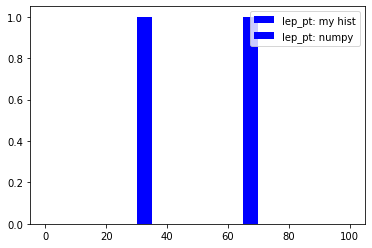

In [54]:
# defining same histogram using full numpy functionality.


var_key = 'lep_pt'
    
np_bin_entries, np_bin_edges = np.histogram(1e-3*particle_arrays[var_key][0], bins=bins, range=[hist_min,hist_max])

print('numpy bin edges: ', np_bin_edges)
print('numpy number of bin edges: ', len(np_bin_edges))
print('numpy number of bin entries: ', len(np_bin_entries))

np_center_bin_edges = np_bin_edges+bin_width/2.

# np_center_bin_edges[:-1] to ignore last bin edge.
plt.bar(center_bin_edges[:-1], bin_entries, width=bin_width, label = f'{var_key}: my hist', color='blue')
plt.bar(np_center_bin_edges[:-1], np_bin_entries, width=bin_width, label = f'{var_key}: numpy', color='blue') 
legend = plt.legend(loc="upper right")


## Particle four-momenta

Particles are described by their four-momentum, which is a four-component vector consisting of their energy and momentum in the three spatial dimensions. This four-momentum vector is known as a Lorentz vector.
The components of a Lorentz vector depend on the frame of reference from which they are measured, and they transform in a specific way under Lorentz transformations, which are the mathematical transformations that relate the measurements made in different frames of reference.

In [ ]:
# write a class that is the four-momentum of a lepton in an event
import math

class four_momentum:
    def __init__(self, pt, eta, phi, E):
        self.pt=pt
        self.eta=eta
        self.phi=phi
        self.E=E
        self.px = self.pt*math.cos(self.phi)
        self.py = self.pt*math.sin(self.phi)
        self.pz = self.pt*math.sinh(self.eta)
    def M(self):
        return math.sqrt(self.E**2 - self.px**2 - self.py**2 - self.pz**2)
    def add(self, four_vec):
        self.E = self.E+four_vec.E
        self.px = self.px + four_vec.px
        self.py = self.py + four_vec.py
        self.pz = self.pz + four_vec.pz
        self.pt = math.sqrt(self.px**2+self.py**2) 
        self.eta = math.asinh(self.pz/self.pt) 
        self.phi = math.acos(self.px/self.pt)
 
dilepton_masses = []

for i in range(100):
    lepton_1 = four_momentum(lep_kinematics['lep_pt'][i][0], lep_kinematics['lep_eta'][i][0], lep_kinematics['lep_phi'][i][0], lep_kinematics['lep_E'][i][0])
    lepton_2 = four_momentum(lep_kinematics['lep_pt'][i][1], lep_kinematics['lep_eta'][i][1], lep_kinematics['lep_phi'][i][1], lep_kinematics['lep_E'][i][1])
    lepton_1.add(lepton_2)
    dilepton = lepton_1
    dilepton_masses.append(dilepton.M())
    
    
print(dilepton_masses)